In [59]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [60]:
class ImgProcessing:
    def __init__(self):
        pass
    
    def CLAHE(self, img):
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(gray)

In [61]:
image_size = 112
batch_size = 8
data_dir =  r"D:\Personal\Ocular Toxoplasmosis\data\BinaryClassification\train"
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

encoded_class_labels = {}
for i in range(len(class_labels)):
    encoded_class_labels[class_labels[i]] = i

In [62]:
class img_dataset:
    def __init__(self, folder_name, labels, encode_labels_dict):  

        self.folder_name = 'D:/Personal/Ocular Toxoplasmosis/data/BinaryClassification/{}'.format(folder_name)
        self.labels = labels
        self.encode_labels_dict = encode_labels_dict
        self.filepath = []
        self.df, self.data_shape, self.label_shape = None, None, None
        self.prepro = ImgProcessing()

    
    def load_dataset(self, grayscale=False, n_data=False):
        data, classes = [], []
        for label in self.labels:
            label_folder = os.path.join(self.folder_name, label)
            img_names = os.listdir(label_folder)# type string (e.g. 'abs12.jpg)            
            for img_name in img_names:
                self.filepath.append(img_name)
                img_path = os.path.join(label_folder, img_name)
                img = cv.imread(img_path)
                # img = self.prepro.CLAHE(img)
                data.append(cv.resize(img,(image_size,image_size)))                
                classes.append(self.encode_labels_dict[label])
        self.df = pd.DataFrame({"filepath" : self.filepath, "label": classes})
        data = np.array(data)
        data = np.expand_dims(data, axis=-1) 
        data = np.repeat(data, 3, axis=-1)
        classes = np.array(classes)
        self.data_shape = data.shape
        self.label_shape = classes.shape
        return data, classes  
    
    def __str__(self) -> str:
        return f"Image Shape: {self.data_shape}\nLabel Shape: {self.label_shape}\nClasses: {self.labels}"


train = img_dataset(labels=class_labels, encode_labels_dict= encoded_class_labels, folder_name='train')
valid = img_dataset(labels=class_labels, encode_labels_dict= encoded_class_labels, folder_name='val')

X_train, Y_train = train.load_dataset(grayscale=False)
X_valid, Y_valid = valid.load_dataset(grayscale=False)

In [63]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

# Convert images to numpy arrays
X_train = np.array(X_train).reshape(len(X_train), -1)
X_val = np.array(X_valid).reshape(len(X_valid), -1)

# Convert labels to numpy arrays
y_train = np.array(Y_train)
y_val = np.array(Y_valid)

print("Converted to 2D")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(298, 112, 112, 3, 3) (298,)
(75, 112, 112, 3, 3) (75,)
Converted to 2D
(298, 112896) (298,)
(75, 112896) (75,)


In [64]:
l = []
def store_metrics(Model, model, Y_test, y_pred):
    
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(Y_test, y_pred)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_test, y_pred, average='macro')
    recall = recall_score(Y_test, y_pred, average='macro')
    f1 = f1_score(Y_test, Y_test, average='macro')
    
    # pred_prob = model.predict_proba(X_val)
    auc_score = roc_auc_score(Y_test, Y_test, multi_class='ovr')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC Score:", auc_score)
    
    # Generate confusion matrix and classification report
    confusion_ = confusion_matrix(Y_test, y_pred)
    classification_= classification_report(Y_test, y_pred, target_names=class_labels)
    
    ax= plt.subplot()
    sns.heatmap(confusion_, ax=ax, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    # labels, title and ticks
    ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels)
    
    print("Confusion Matrix:")
    print(confusion_)
    print("Classification Report:")
    print(classification_)

    l.append([Model, accuracy, precision, recall, f1, auc_score, confusion_, classification_])

## RandomForestClassifier

Accuracy: 0.68
Precision: 0.3541666666666667
Recall: 0.4722222222222222
F1 Score: 1.0
AUC Score: 1.0
Confusion Matrix:
[[51  3]
 [21  0]]
Classification Report:
              precision    recall  f1-score   support

    abnormal       0.71      0.94      0.81        54
     healthy       0.00      0.00      0.00        21

    accuracy                           0.68        75
   macro avg       0.35      0.47      0.40        75
weighted avg       0.51      0.68      0.58        75



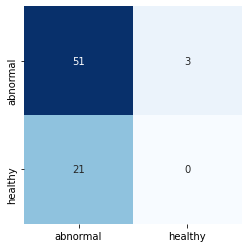

In [65]:
from sklearn.ensemble import RandomForestClassifier

random = RandomForestClassifier(n_estimators=100, random_state=42)
random.fit(X_train, y_train)

y_pred_random = random.predict(X_val)
store_metrics("RandomForset", random, y_val, y_pred_random)

## KNeighborsClassifier

Accuracy: 0.5866666666666667
Precision: 0.5211930926216641
Recall: 0.5238095238095237
F1 Score: 1.0
AUC Score: 1.0
Confusion Matrix:
[[36 18]
 [13  8]]
Classification Report:
              precision    recall  f1-score   support

    abnormal       0.73      0.67      0.70        54
     healthy       0.31      0.38      0.34        21

    accuracy                           0.59        75
   macro avg       0.52      0.52      0.52        75
weighted avg       0.62      0.59      0.60        75



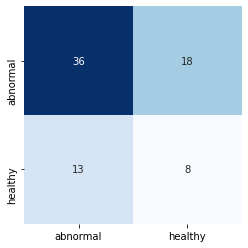

In [67]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

store_metrics("KNeighborsClassifier", knn, y_val, y_pred_knn)

## GradientBoostingClassifier

Accuracy: 0.6533333333333333
Precision: 0.35
Recall: 0.4537037037037037
F1 Score: 1.0
AUC Score: 1.0
Confusion Matrix:
[[49  5]
 [21  0]]
Classification Report:
              precision    recall  f1-score   support

    abnormal       0.70      0.91      0.79        54
     healthy       0.00      0.00      0.00        21

    accuracy                           0.65        75
   macro avg       0.35      0.45      0.40        75
weighted avg       0.50      0.65      0.57        75



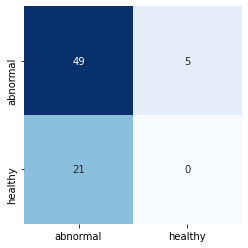

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

GRADIENT = GradientBoostingClassifier(n_estimators=5, random_state=42)
GRADIENT.fit(X_train, y_train)

y_pred_GRADIENT = GRADIENT.predict(X_val)
store_metrics("GradientBoostingClassifier", GRADIENT, y_val, y_pred_GRADIENT)

## AdaBoostClassifier

Accuracy: 0.7333333333333333
Precision: 0.8648648648648649
Recall: 0.5238095238095238
F1 Score: 1.0
AUC Score: 1.0
Confusion Matrix:
[[54  0]
 [20  1]]
Classification Report:
              precision    recall  f1-score   support

    abnormal       0.73      1.00      0.84        54
     healthy       1.00      0.05      0.09        21

    accuracy                           0.73        75
   macro avg       0.86      0.52      0.47        75
weighted avg       0.81      0.73      0.63        75



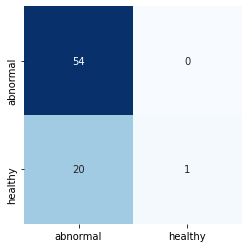

In [69]:
from sklearn.ensemble import AdaBoostClassifier
ADA = AdaBoostClassifier(n_estimators=5, random_state=42)
ADA.fit(X_train, y_train)

y_pred_ADA = ADA.predict(X_val)
store_metrics("AdaBoostClassifier", ADA, y_val, y_pred_ADA)

## GaussianNB

Accuracy: 0.72
Precision: 0.36
Recall: 0.5
F1 Score: 1.0
AUC Score: 1.0
Confusion Matrix:
[[54  0]
 [21  0]]
Classification Report:
              precision    recall  f1-score   support

    abnormal       0.72      1.00      0.84        54
     healthy       0.00      0.00      0.00        21

    accuracy                           0.72        75
   macro avg       0.36      0.50      0.42        75
weighted avg       0.52      0.72      0.60        75



C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HSSL77\anaconda3\envs\tf_gpu_final\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HS

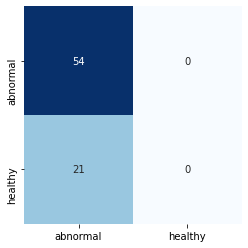

In [70]:
from sklearn.naive_bayes import GaussianNB
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)

y_pred_Gaussian = Gaussian.predict(X_val)
store_metrics("GaussianNB", Gaussian, y_val, y_pred_Gaussian)

In [74]:
df = pd.DataFrame(l) 
df

,0,1,2,3,4,5,6,7
0,RandomForset,0.680000,0.354167,0.472222,1.0,1.0,"[[51, 3], [21, 0]]",precision recall f1-score ...
1,KNeighborsClassifier,0.586667,0.521193,0.523810,1.0,1.0,"[[36, 18], [13, 8]]",precision recall f1-score ...
2,GradientBoostingClassifier,0.653333,0.350000,0.453704,1.0,1.0,"[[49, 5], [21, 0]]",precision recall f1-score ...
3,AdaBoostClassifier,0.733333,0.864865,0.523810,1.0,1.0,"[[54, 0], [20, 1]]",precision recall f1-score ...
4,GaussianNB,0.720000,0.360000,0.500000,1.0,1.0,"[[54, 0], [21, 0]]",precision recall f1-score ...


In [73]:
for i in l:
    for j in i:
        print(j)

RandomForset
0.68
0.3541666666666667
0.4722222222222222
1.0
1.0
[[51  3]
 [21  0]]
              precision    recall  f1-score   support

    abnormal       0.71      0.94      0.81        54
     healthy       0.00      0.00      0.00        21

    accuracy                           0.68        75
   macro avg       0.35      0.47      0.40        75
weighted avg       0.51      0.68      0.58        75

KNeighborsClassifier
0.5866666666666667
0.5211930926216641
0.5238095238095237
1.0
1.0
[[36 18]
 [13  8]]
              precision    recall  f1-score   support

    abnormal       0.73      0.67      0.70        54
     healthy       0.31      0.38      0.34        21

    accuracy                           0.59        75
   macro avg       0.52      0.52      0.52        75
weighted avg       0.62      0.59      0.60        75

GradientBoostingClassifier
0.6533333333333333
0.35
0.4537037037037037
1.0
1.0
[[49  5]
 [21  0]]
              precision    recall  f1-score   support

    ab